## Import

In [1]:
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange
from itertools import product

# import ray

In [2]:
import torch

In [3]:
%load_ext autoreload
%autoreload 2

## Data

### Datasets

In [4]:
from community.data.datasets.generate import get_datasets_symbols, get_datasets_alphabet
from community.utils.plotting import plot_grid, create_gifs
from community.data.tasks import get_task_target, get_factors_list, get_task_family
from community.utils.nested import nested_shape, nested_len, nested_round, nested_sup
from community.common.models.ensembles import Community
from community.common.models.readout import configure_readouts
from community.common.decision import get_decision


In [5]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512

In [511]:
use_symbols = False
load_all = False


n_agents = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_agents

data_config = {
    "batch_size": 512,
    "data_size": None,  # np.array([30000, 5000]) ,
    "input_size": 28,
    "common_input": True,
    "use_cuda": use_cuda,
    "fix_asym": False,
    "permute_dataset": True,
    "seed": np.random.randint(100),
    "data_type": "symbols" if use_symbols else "double_d",
    "n_digits": n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "symbol_config": {},
    "split_classes": True,
    "nb_steps": 2,
}

if use_symbols or load_all:

    symbol_config = {
        "data_size": (np.array([30000, 5000]) // (max(data_config['nb_steps'] // 5, 0.5))).astype(int) ,
        "nb_steps": data_config["nb_steps"],
        "n_symbols": n_classes - 1,
        "symbol_type": "mod_5",
        "input_size": 60,
        "static": True,
        "n_diff_symbols": n_agents,
        "parallel": False,
        "adjust_probas": False,
        "random_transform": True,
        "cov_ratio" : 1
    }

    if not symbol_config["static"]:
        symbol_config["nb_steps"] = 10

    n_bits = np.ceil(np.log2(n_classes)).astype(int)

    data_config["symbol_config"] = symbol_config
    data_config["input_size"] = symbol_config["input_size"]
    data_config["data_type"] = "symbols"
    # loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)

    symbol_config['data_size']


elif data_config['data_type'] == 'double_d' : 
    n_classes_per_digit = min(n_classes_per_digit, 10)
    n_classes = n_classes_per_digit * n_agents
    data_config['n_classes'] = n_classes
    data_config['n_classes_per_digit'] = n_classes_per_digit




In [512]:
if load_all : 
    sym_loaders, sym_datasets = get_datasets_symbols(
        data_config, batch_size, use_cuda, plot=True
    )
    all_loaders = get_datasets_alphabet("../../data/", data_config)
    mnist_loaders = all_loaders[
        ["multi", "double_d", "double_l", "single_d" "single_l"].index(
            'double_d'
        )
    ]
    mnist_datasets = [l.dataset for l in mnist_loaders]
   
elif use_symbols:
    loaders, datasets = get_datasets_symbols(
        data_config, batch_size, use_cuda, plot=True
    )
else:

    all_loaders = get_datasets_alphabet("../../data/", data_config)
    loaders = all_loaders[
        ["multi", "double_d", "double_l", "single_d" "single_l"].index(
            data_config["data_type"]
        )
    ]

    datasets = [l.dataset for l in loaders]


### Profile

In [57]:
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm.notebook import tqdm

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    for data, t in tqdm(mnist_loaders[1]) : 
        pass

STAGE:2023-03-15 13:31:53 114457:114457 ActivityProfilerController.cpp:310] Completed Stage: Warm Up


NameError: name 'mnist_loaders' is not defined

STAGE:2023-03-15 13:31:53 114457:114457 ActivityProfilerController.cpp:316] Completed Stage: Collection
STAGE:2023-03-15 13:31:53 114457:114457 ActivityProfilerController.cpp:320] Completed Stage: Post Processing


In [64]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        62.37%      54.221ms        99.96%      86.895ms       4.345ms            20  
                                           aten::select        26.78%      23.284ms        26.96%      23.433ms       1.204us         19456  
                                            aten::stack         4.21%       3.658ms        10.63%       9.238ms     243.105us            38  
                                              aten::cat         6.14%       5.339ms         6.39%       5.558ms     146.263us            38  
      

In [65]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    for data, t in tqdm(sym_loaders[1]) : 
        pass

STAGE:2023-03-15 12:17:37 113450:113450 ActivityProfilerController.cpp:310] Completed Stage: Warm Up


  0%|          | 0/19 [00:00<?, ?it/s]

STAGE:2023-03-15 12:17:38 113450:113450 ActivityProfilerController.cpp:316] Completed Stage: Collection
STAGE:2023-03-15 12:17:38 113450:113450 ActivityProfilerController.cpp:320] Completed Stage: Post Processing


In [66]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        99.97%     594.998ms        99.99%     595.135ms      29.757ms            20  
                               cudaPointerGetAttributes         0.02%     137.000us         0.02%     137.000us       3.605us            38  
                                          aten::random_         0.00%      24.000us         0.00%      24.000us      24.000us             1  
                                            aten::empty         0.00%      15.000us         0.00%      15.000us      15.000us             1  
      

### Plot / stats

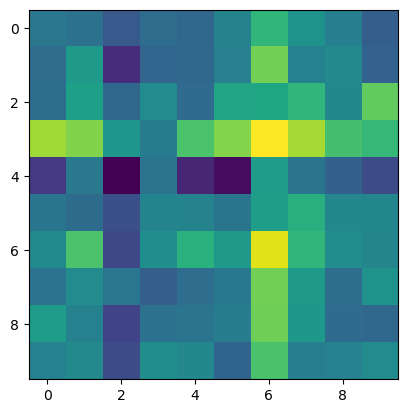

In [227]:
uniques = datasets[0].data[1].unique(return_counts=True, dim=0)
try : 
    un = uniques[1].reshape(n_classes_per_digit, n_classes_per_digit)
    plt.imshow(un.cpu().data.numpy())
except ValueError : 
    print(un)

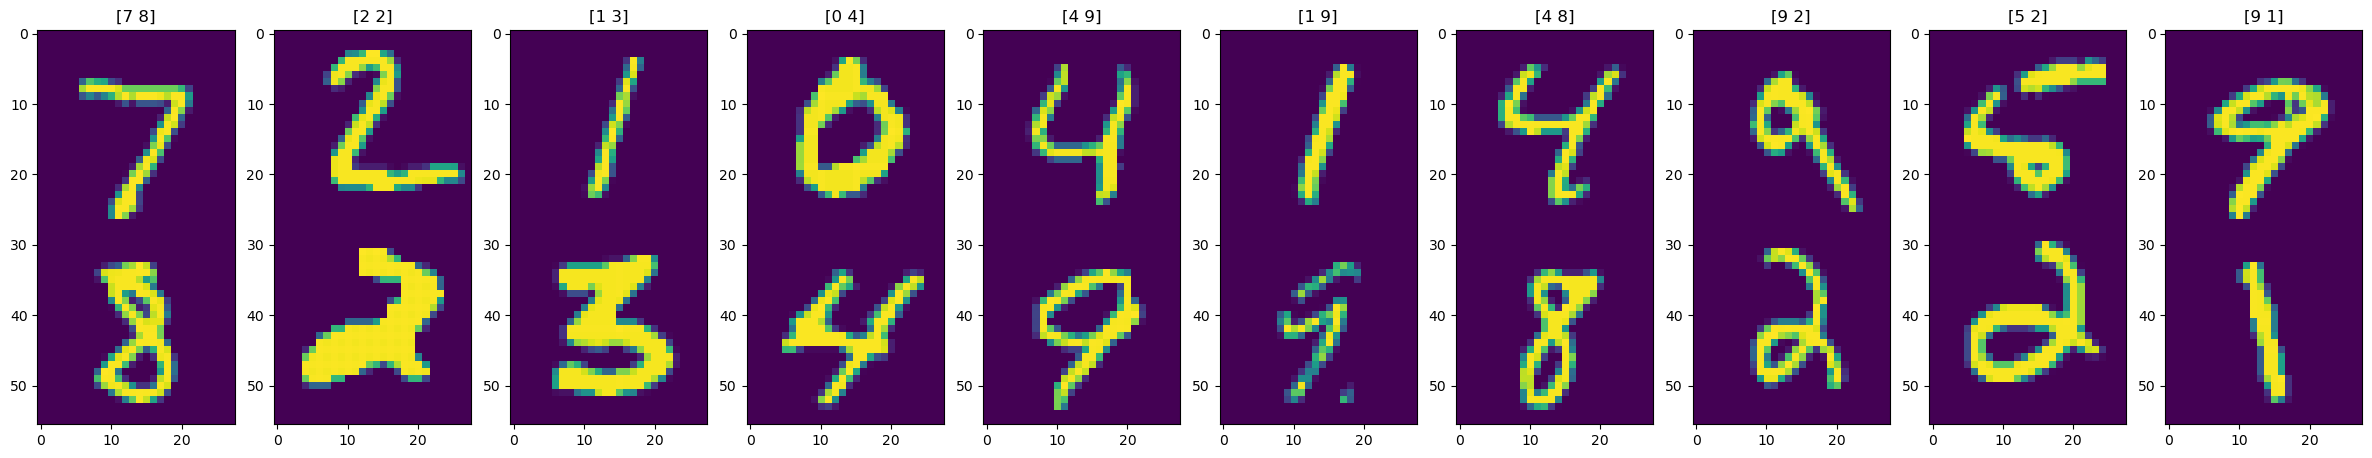

In [383]:
if use_symbols:
    data, targets = datasets[0].data[:-1]
    s = 50
    fig, axs = plt.subplots(1, 10, figsize=(30, 20))
    if symbol_config["static"]:
        for i, ax in enumerate(axs):
            if not data_config["common_input"]:
                ax.imshow(data[i + s][-1].reshape(120, 60))
                ax.set_title(targets[i + s].data.numpy())
            else:
                ax.imshow(data[i + s][-1].reshape(60, 60))
                ax.set_title(targets[i + s].data.numpy())

    else:
        for i, ax in enumerate(axs):
            if not data_config["common_input"]:
                ax.imshow(data[s][i].reshape(120, 60))
                ax.set_title(targets[s].data.numpy())
            else:
                ax.imshow(data[s][i].reshape(60, 60))
                ax.set_title(targets[i + s].data.numpy())

        create_gifs(
            data, common_input=data_config["common_input"], input_size=60, name=""
        )
else:
    s = 0
    data, targets = next(iter(loaders[1]))
    fig, axs = plt.subplots(1, 10, figsize=(30, 20))
    for i, ax in enumerate(axs):
        if data_config["data_type"] in ["double_d", "double_l", "multi"]:
            ax.imshow(data[i + s].reshape(2 * 28, 28))
            ax.set_title(targets[i + s].data.numpy())
        else:
            ax.imshow(data[i + s].reshape(28, 28))
            ax.set_title(targets[i + s].data.numpy())


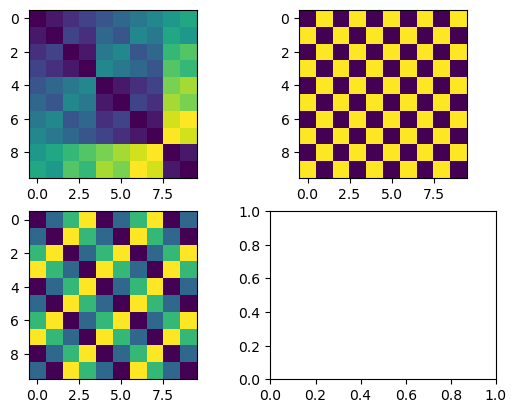

In [232]:
from itertools import product

pairs = torch.tensor(
    list(product(torch.arange(n_classes_per_digit), repeat=2)), dtype=int
)
fig, axs = plt.subplots(2, 2)
n_bits = int(np.log2(n_classes_per_digit))
for task, ax in zip(
    ["bitxor"] + [f"bitxor-last-{i}" for i in range(1, n_bits)], axs.flatten()
):
    xor = get_task_target(pairs, task, n_classes_per_digit).reshape(
        n_classes_per_digit, n_classes_per_digit
    )
    ax.imshow(xor)

In [118]:
all_targets = datasets[0].data[1]
print(all_targets.unique(return_counts=True))
task = "parity-digits"
t_targets = get_task_target(all_targets, task, n_classes_per_digit)
print(t_targets.unique(return_counts=True))
print([(t_targets == t).sum() for t in all_targets.T])

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([11846, 13484, 11916, 12262, 11684, 10842, 11836, 12530, 11702, 11898]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5796, 6808, 5959, 6130, 5963, 5425, 5924, 6220, 5850, 5925]))
[tensor(36156), tensor(29804)]


In [12]:
if False:

    task = "parity-equal"

    uniques, unique_counts = all_targets.unique(dim=0, return_counts=True)
    task_t = get_task_target(all_targets, task, n_classes_per_digit)
    task_t.unique(dim=0, return_counts=True), (all_targets[:, 0] == task_t).unique(
        dim=0, return_counts=True
    ), (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)
    digits_in = lambda d1, d2: (torch.tensor([d1, d2]) == uniques).all(1).any()
    digits_idx = (
        lambda d1, d2: (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
    )
    counts = np.zeros((n_classes_per_digit + 1, n_classes_per_digit + 1))
    targets = np.zeros((n_classes_per_digit + 1, n_classes_per_digit + 1), dtype=object)

    for d1 in range(n_classes_per_digit):
        counts[d1, -1] = (
            (all_targets[:, 0] == task_t)[all_targets[:, 0] == d1]
        ).sum()  # unique_counts[(uniques == d1)[:, 0]].sum()
        targets[d1, -1] = str(counts[d1, -1])
        for d2 in range(n_classes_per_digit):
            if digits_in(d1, d2):
                counts[d1, d2] = unique_counts[digits_idx(d1, d2)]
                targets[
                    d1, d2
                ] = f"{get_task_target(uniques, task, n_classes_per_digit)[digits_idx(d1, d2)].cpu().data.item()} | {unique_counts[digits_idx(d1, d2)]}"
            else:
                counts[d1, d2] = -0.1
                targets[d1, d2] = "X"
            counts[-1, d2] = (
                (all_targets[:, 1] == task_t)[all_targets[:, 1] == d2]
            ).sum()  # unique_counts[(uniques == d2)[:, 1]].sum()
            targets[-1, d2] = str(counts[-1, d2])

    counts[-1, -1] = unique_counts.sum().cpu().data.item()
    targets[-1, -1] = str(
        f"D0 : {(all_targets[:, 0] == task_t).unique(dim=0, return_counts=True)[1][1]} \n"
        + f"D1 : {(all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)[1][1]}"
    )

    plt.figure(figsize=(10, 10), dpi=100)
    ax = sns.heatmap(
        counts, cmap="inferno", annot=targets, annot_kws={"fontsize": 8}, fmt="s"
    )
    ax.set_title("Number of examples and global targets")

    ax.set_xlabel("Digit received by Agent 1")
    ax.set_ylabel("Digit received by Agent 0")
    ax.set_xticklabels([str(i) for i in range(n_classes_per_digit)] + ["dig=global"])
    ax.set_yticklabels([str(i) for i in range(n_classes_per_digit)] + ["dig=global"])

    plt.show()

## Init

In [631]:
from community.funcspec.single_model_loop import (
    init_and_train,
    train_and_compute_metrics,
    init_community,
    init_optimizers,
)

from community.common.training import train_community, get_acc, get_loss
from community.common.models.ensembles import Community
from community.data.process import process_data
from community.utils.configs import (
    get_training_dict,
)
import yaml
from yaml.loader import SafeLoader

with open("../../latest_config.yml", "r") as config_file:
    config = yaml.load(config_file, SafeLoader)


try shared goals with sum

Implement a task str-parsing function

In [773]:
n_conns = [0]
configs = []

for n in n_conns:

    with open("../../latest_config.yml", "r") as config_file:
        config = yaml.load(config_file, SafeLoader)

    # task = config["task"] = [ str(i) for i in range(n_agents)]  # "family"  # [[str(i), str((i+1)%3)] for i in range(3)]
    # task = config["task"] = [['0', '1'], ['1', '2'], ['0', '2']] #"both"

    config["datasets"] = data_config

    # task = config["task"] = ["bitxor", 'bitxor-last-2', 'bitxor-last-1', 'bitxor-first-2', 'bitxor-first-1']
    #task =  config["task"] = ['parity-digits-sum', '0', '1']
    task = config["task"] = ['1', '0']
    
    config["model"]["agents"]["n_in"] = data_config["input_size"] ** 2 * (
        1 + data_config["common_input"] * (1 - use_symbols)
    )

    n_hidden = config["model"]["agents"]["n_hidden"] = 10
    n_layers = config["model"]["agents"]["n_layers"] = 1
    n_bot = config["model"]["agents"]["n_bot"] = 5
    config['model']['agents']['ag_dropout'] = 0.
    config["model"]["n_agents"] = n_agents

    common_readout = config["model"]["readout"]["common_readout"] = False
    config["model"]["readout"]["n_hid"] = None
    config["model"]["readout"]["readout_from"] = None

    readout_config = configure_readouts(config)
    config["model"]["readout"].update(readout_config)

    sparsity = config["model"]["connections"]["sparsity"] = n / n_hidden**2  # .005
    config["model"]["connections"]["comms_out_scale"] = 1
    config["model"]["connections"]["comms_start"] = "start"
    config["model"]["connections"]["binarize"] = False

    decision = config["training"]["decision"] = [
        "last",
        "all" if common_readout else "self",
    ]

    n_epochs = config["training"]["n_epochs"] = 15

    configs.append(config)

print(
   f'Training {n_agents} agents of size {n_hidden} on task {task} using {"common"*common_readout + "separate"*(1-common_readout)} readout and decision {decision}, with {sparsity * n_hidden**2} connections and { config["model"]["readout"]["n_out"] } outputs'
)

Training 2 agents of size 10 on task ['1', '0'] using separate readout and decision ['last', 'self'], with 0.0 connections and [10, 10] outputs


In [774]:
readout_config

{'readout_from': [None, None],
 'n_hid': [None, None],
 'n_readouts': [1, 1],
 'n_out': [10, 10]}

In [775]:
networks, optimizers = [], []

for config in configs:

    community = init_community(config["model"], device=device)

    reg_readout = 0

    if not reg_readout:
        optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

    else:
        optimizer = torch.optim.AdamW(
            [p for n, p in community.named_parameters() if "readout" not in n], lr=1e-3
        )
        optimizer.add_param_group(
            {
                "params": [
                    p for n, p in community.named_parameters() if "readout" in n
                ],
                "lr": 1e-3,
                "weight_decay": reg_readout,
            }
        )

    config["use_tqdm"] = True
    community.nb_connections

    networks.append(community), optimizers.append(optimizer)

In [776]:
community.readout

In [777]:
data, target = next(iter(loaders[0]))
data, target = process_data(
    data,
    target,
    symbols=use_symbols,
    task=task,
    n_steps=data_config['nb_steps'],
    common_input=config["datasets"]["common_input"],
)
data, target = data.to(device), target.to(device)
t_target = get_task_target(target, task, n_classes_per_digit)
output, out_dict = community(data)

try:
    print(output.shape)
except AttributeError:
    print(nested_shape(output))
# print(data.shape)


torch.Size([2, 2, 2, 512, 10])


In [778]:
out = get_decision(output, *decision)[0]
print(nested_shape(output))
acc = get_acc(out, t_target, both=decision[1] == "both")
print(nested_round(acc))

get_loss(out, t_target, both=decision[1] == "both").shape

[torch.Size([2, 2, 2, 512, 10])]
[13.0, 7.0]


torch.Size([2, 512])

## Training

In [779]:
model_load = False
model_save = True

n_epochs = 5
community.to(device)

config['training']['check_gradients'] = False

def train(
    community=community, optimizers=[optimizer, None], n_epochs=n_epochs, test=False, masks=None
):
    return train_community(
        community,
        *loaders,
        optimizers=optimizers,
        config=get_training_dict(config),
        n_epochs=n_epochs if not test else 1,
        trials=(not test, True),
        show_all_acc=True,
        use_tqdm=not test,
        device=device,
        ag_masks=masks
    )

train_results = [
    train(community, [optimizer, None])
    for community, optimizer in zip(networks, optimizers)
]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

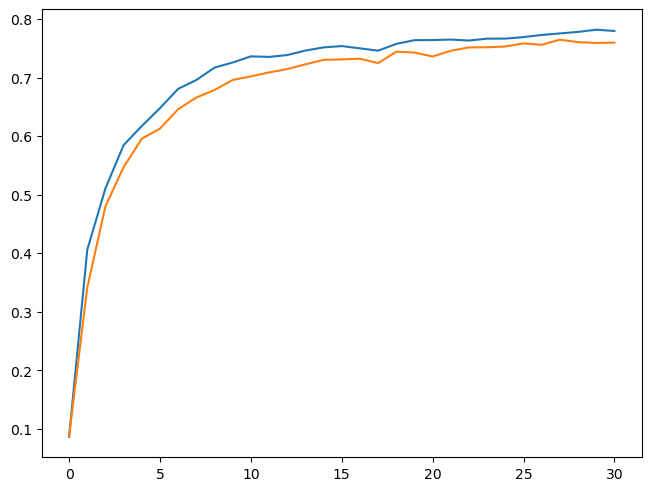

In [522]:
fig, axs = plt.subplots(2 - common_readout, len(networks), constrained_layout=True, sharey=True)
try : 
    axs[0]
except TypeError : 
    axs = [axs]
try : 
    [[ax.plot(t['test_accs'][:, ag] ) for t, ax in zip(train_results, ag_axs)] for ag, ag_axs in enumerate(axs)];
except TypeError : 
    [ax.plot(t['test_accs']) for t, ax in zip(train_results, axs)]

In [ ]:
raise StopIteration

StopIteration: 

In [ ]:
train_results = [
    train(community, [optimizer, None], n_epochs=2, masks=[torch.ones(n_hidden) * i for i in [1, 0]])
    for community, optimizer in zip(networks, optimizers)
]

## Binary representations 

In [ ]:
import torch.nn.functional as F


def binary_conn(target):
    encoding = [[] for _ in range(2)]
    for ag in range(2):
        encoded_target = target[:, ag].clone().detach()
        for d in range(n_bits - 1, -1, -1):
            encoding[ag].append(
                torch.div(encoded_target, 2**d, rounding_mode="floor")
            )
            encoded_target -= (
                torch.div(encoded_target, 2**d, rounding_mode="floor") * 2**d
            )
    return torch.stack([torch.stack(e, -1) for e in encoding])


### Minimal model

In [ ]:
task = "0"

n_epochs = 10
if "last" in task:
    n_last = int(task.split("-")[-1])
    n_out = 2**n_last
else:
    n_out = n_classes_per_digit

n_out = 2 * n_classes_per_digit

n_in = 5

minimal_model = nn.Sequential(nn.Linear(n_in, 30), nn.ReLU(), nn.Linear(30, n_out))
# minimal_model = nn.Linear(n_in, n_out)
optim = torch.optim.Adam(minimal_model.parameters(), lr=1e-2)


In [ ]:
minimal_input = torch.cat([ago[-1] for ago in ag_outs], -1)
minimal_input.shape

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
community.to("cpu")
pbar_e = tqdm(range(n_epochs), position=0, leave=None, desc="Epochs ")
desc = np.array(["", ""], dtype=object)
for e in pbar_e:

    for b, (data, target) in enumerate(loaders[0]):

        data, target = process_data(
            data,
            target,
            symbols=use_symbols,
            task=task,
            n_steps=10,
            common_input=config["datasets"]["common_input"],
        )

        # minimal_input = torch.cat([*binary_conn(target)], -1).float()
        # minimal_input = torch.cat([minimal_input, torch.rand_like(minimal_input)], -1)
        out, states, ag_outs, fconns = community(data)
        # minimal_input = torch.cat([ago[-1] for ago in ag_outs], -1).squeeze()
        minimal_input = ag_outs[-1][1 - int(task)]

        minimal_output = minimal_model(minimal_input)
        t_target = get_task_target(target, task, n_classes=n_classes_per_digit)

        loss = F.cross_entropy(minimal_output, t_target, reduction="mean")
        optim.zero_grad()
        loss.backward()
        optim.step()

        pred = minimal_output.argmax(dim=-1)
        correct = pred.eq(t_target.view_as(pred))
        acc = (
            (correct.sum(-1) * np.prod(t_target.shape[:-1]) / t_target.numel())
            .cpu()
            .data.numpy()
        )

        desc[0] = f"Epochs : {b}/{len(loaders[0])}, Acc = {acc:.2f}, Loss = {loss:.2f}"
        pbar_e.set_description(desc.sum(0))

    for b, (data, target) in enumerate(loaders[1]):

        data, target = process_data(
            data,
            target,
            symbols=use_symbols,
            task=task,
            n_steps=10,
            common_input=config["datasets"]["common_input"],
        )

        # minimal_input = torch.cat([*binary_conn(target)], -1).float()
        # minimal_input = torch.cat([minimal_input, torch.rand_like(minimal_input)], -1)
        out, states, ag_outs, fconns = community(data)
        minimal_input = torch.cat([ago[-1] for ago in ag_outs], -1).squeeze()
        minimal_input = ag_outs[-1][1 - int(task)]

        minimal_output = minimal_model(minimal_input)
        t_target = get_task_target(target, task, n_classes=n_classes_per_digit)

        loss = F.cross_entropy(minimal_output, t_target, reduction="mean")
        pred = minimal_output.argmax(dim=-1)
        correct = pred.eq(t_target.view_as(pred))
        acc = (
            (correct.sum(-1) * np.prod(t_target.shape[:-1]) / t_target.numel())
            .cpu()
            .data.numpy()
        )

        desc[1] = f"| Test :  Acc = {acc:.2f}, Loss = {loss:.2f}"
        pbar_e.set_description(desc.sum(0))


Epochs :   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
minimal_input.shape

torch.Size([1, 256, 10])

## Retraining : 

### Readout Only

In [ ]:
task = config["task"] = "parity-digits"
config["model"]["readout_n_hid"] = 2

configure_readouts(config)


community.n_readouts = config["model"]["n_readouts"]


community.initialize_readout(
    config["model"]["n_readouts"],
    config["model"]["readout_from"],
    config["model"]["readout_n_hid"] = 2
)
                    
community.to(device)

config["training"]["n_epochs"] = 20
# config["task"] = [str(i) for i in range(n_agents)]

optimizer = torch.optim.Adam(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
    )


In [ ]:
train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True,
)

Train Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

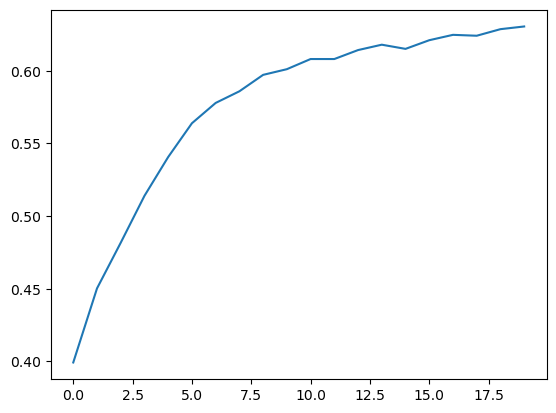

In [ ]:
plt.plot(train_results["test_accs"])


In [ ]:
config["model"]


{'agents': {'ag_dropout': 0.0,
  'cell_type': "<class 'torch.nn.modules.rnn.RNN'>",
  'n_hidden': 50,
  'n_in': 3600,
  'n_layers': 1,
  'n_out': 10,
  'n_readouts': None,
  'train_in_out': [True, True],
  'use_bottleneck': False},
 'common_readout': True,
 'connections': {'binarize': True,
  'comms_dropout': 0.0,
  'comms_start': 'start',
  'sparsity': 0.8,
  'use_deepR': False},
 'n_agents': 2,
 'n_ins': None,
 'n_readouts': 1,
 'readout_from': None}

In [ ]:
plt.plot(train_results["test_accs"])

In [ ]:
freeze_retrain = True

task = config["task"] = "inv_parity-digits"
# task = config["task"] = 'both'
# task = config["task"] = [["0", "1"], ["1", "2"], ["0", "2"]]
# task = config["task"] = ["0", "1", "max", "min"]

config["model"]["n_agents"] = 2
config["model"]["agents"]["n_hidden"] = 10
common_readout = config["model"]["common_readout"] = True

configure_readouts(config)

if not freeze_retrain:

    community = init_community(config["model"])

community.n_readouts = config["model"]["n_readouts"]
config["model"]["readout_n_hid"] = 10
config["model"]["connections"]["sparsity"] = 0.0
community.use_common_readout = True

for ag in community.agents:
    ag.dims[-1] = n_classes

community.initialize_readout(
    config["model"]["n_readouts"],
    config["model"]["readout_from"],
    config["model"]["readout_n_hid"],
)

community.to(device)

reg_readout = 1

if freeze_retrain:

    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
        weight_decay=reg_readout,
    )

else:
    if not reg_readout:
        optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)
    else:
        optimizer = torch.optim.AdamW(
            [
                p
                for n, p in community.named_parameters()
                if n not in ["readout.0", "readout.1"]
            ],
            lr=1e-3,
        )
        optimizer.add_param_group(
            {
                "params": [
                    p
                    for n, p in community.named_parameters()
                    if n in ["readout.0", "readout.1"]
                ],
                "lr": 1e-3,
                "weight_decay": reg_readout,
            }
        )

data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

out, states, fconns = community(data)

print(out.shape)


In [ ]:
class New_community(nn.Module):
    def __init__(self, community, task="family") -> None:
        super().__init__()
        self.community = community
        self.connections = {}

        if task == "family":
            self.dim_out = [len(get_factors_list(n_agents)), n_classes]
        elif isinstance(task, list):
            self.dim_out = [len(task), n_classes]
        else:
            self.dim_out = [2, n_classes_per_digit]

        self.readout = nn.Linear(20, np.prod(self.dim_out))

    def forward(self, x, conns=0):
        out, states, conns = self.community(x)
        new_out = self.readout(torch.cat([o for o in out[-1]], -1))
        new_out = new_out.reshape(-1, *self.dim_out).transpose(0, 1).unsqueeze(0)

        return new_out, states, conns

In [ ]:
task = config["task"] = "both"
task = config["task"] = ["0", "1", "bitand", "bitor", "max", "min"]

community = init_community(config["model"])


new_com = New_community(community, task).to(device)
new_com.is_community = True


optimizer = torch.optim.AdamW(
    [
        p
        for n, p in new_com.named_parameters()
        if n in ["readout.weight", "readout.bias"]
    ],
    lr=1e-3,
    weight_decay=reg_readout,
)

optimizer = torch.optim.Adam(new_com.parameters(), lr=1e-3)

In [ ]:
data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

new_com(data)[0].shape

In [ ]:
config["training"]["n_epochs"] = 10

train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True
)

In [ ]:
if task == "family":
    label = [str(t.data.numpy()) for t in get_factors_list(n_agents)]
elif isinstance(task, list):
    label = task
elif task in ["both", "all"]:
    labem = ["0", "1"]
else:
    label = None
plt.plot(train_results["test_accs"], label=label)
plt.legend()
plt.show()

## Analysis


### PCA on agent outs

In [174]:
def binary_conn(target):
    encoding = [[] for _ in range(2)]
    for ag in range(2):
        encoded_target = target[:, ag].clone().detach()
        for d in range(n_bits - 1, -1, -1):
            encoding[ag].append(
                torch.div(encoded_target, 2**d, rounding_mode="floor")
            )
            encoded_target -= (
                torch.div(encoded_target, 2**d, rounding_mode="floor") * 2**d
            )
    return torch.stack([torch.stack(e, -1) for e in encoding])


In [175]:
data, target = next(iter(loaders[0]))
data, target = process_data(
    data,
    target,
    symbols=use_symbols,
    task=task,
    n_steps=config["datasets"]["nb_steps"],
    common_input=config["datasets"]["common_input"],
)
data, target = data.to(device), target.to(device)

out, out_dict = community(data)


In [176]:
from sklearn.decomposition import PCA


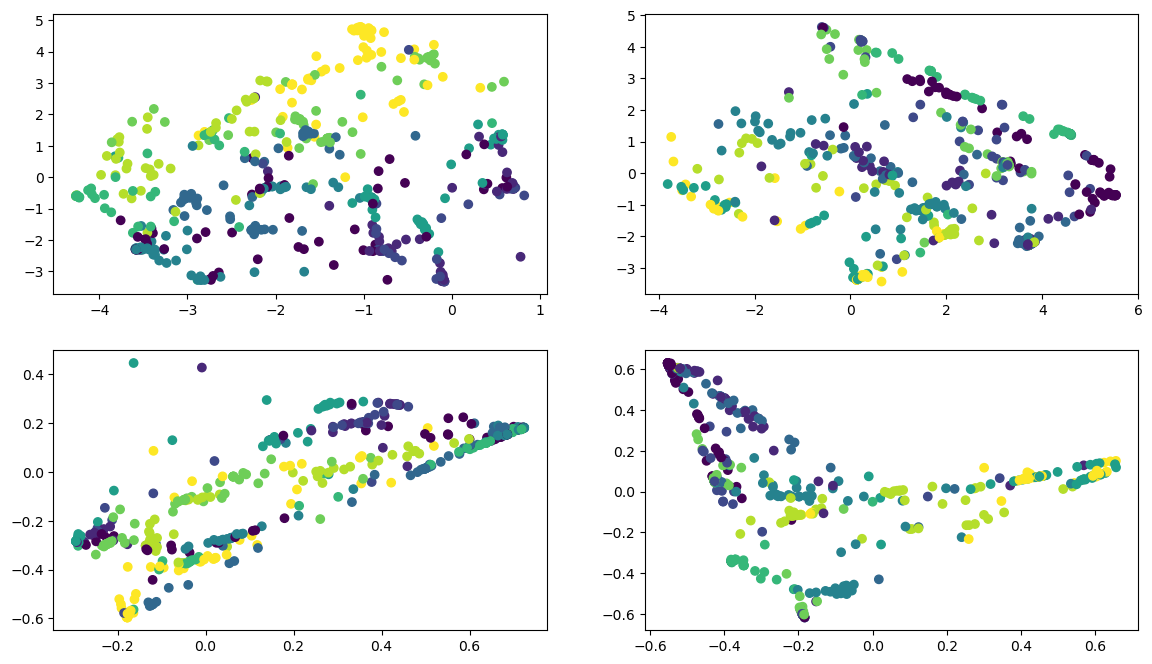

In [177]:
ag_bott = out_dict["ag_bottlenecks"]

ag_out = [
    torch.cat([*[ag[-1] for ag in ag_bott]], 1).squeeze(),
    torch.cat([*[ag[-1] for ag in ag_bott]], 1).softmax(-1).squeeze(),
]


fig, axs = plt.subplots(2, 2, figsize=(14, 8))
for i, axs_soft in enumerate(axs):
    pca = PCA(2)
    pca_out = pca.fit_transform(ag_out[i].cpu().data.numpy())
    for ag, ax in enumerate(axs_soft):
        ax.scatter(*pca_out[batch_size * ag : batch_size * (ag + 1)].T, c=target[:, ag])

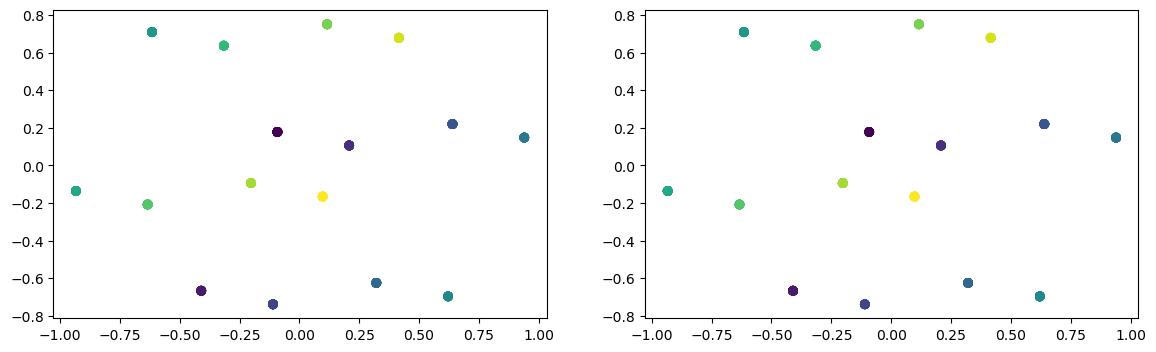

In [ ]:
pca = PCA(2)
binary_target = torch.cat([*binary_conn(target)], 0)
pca_out = pca.fit_transform(binary_target.cpu().data.numpy())
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for ag, ax in enumerate(axs):
    ax.scatter(*pca_out[256 * ag : 256 * (ag + 1)].T, c=target[:, ag])


### Readouts

In [173]:
if task == "family":
    task_f = [t.data.numpy() for t in get_factors_list(data_config["n_diff_symbols"])]
elif isinstance(task, list):
    task_f = task
else:
    if "both" in task:
        task_f = [0, 1]
    else:
        task_f = [task]

fig = plt.figure(constrained_layout=True, figsize=(5 * len(community.readout), 5))
fig.suptitle("Readout Weights")

# create 3x1 subfigs
subfigs = fig.subfigures(1, len(community.readout))
if len(community.readout) == 1:
    subfigs = [subfigs]

for readout, subfig, t in zip(community.readout, subfigs, task_f):

    subfig.suptitle(t)

    if hasattr(readout, "__len__"):

        if hasattr(readout[0], "__len__"):
            axs = subfig.subplots(len(readout[0]) - 1, len(readout))
            for ax_r, r in zip(axs, readout):
                l = 0
                for layer in r:
                    if hasattr(layer, "weight"):
                        ax = ax_r[l]
                        w = layer.weight.cpu().data.numpy()
                        ax.imshow(w)
                        ax.set_title(f"Layer {l}")
                        l += 1
        else:
            axs = subfig.subplots(
                len(readout) - 1 * isinstance(readout, nn.Sequential), 1
            )
            if not hasattr(axs, "__len__"):
                axs = [axs]
            layer = 0
            for r in readout:
                if hasattr(r, "weight"):
                    ax = axs[layer]
                    w = r.weight.cpu().data.numpy()
                    ax.imshow(w)
                    if layer == 0:
                        ax.vlines(
                            [w.shape[1] // 2],
                            -0.01,
                            w.shape[0],
                            color="black",
                            linewidth=2,
                        )
                    ax.set_title(f"Readout {layer}")
                    layer += 1

    else:
        ax = subfig.subplots(1, 1)
        w = readout.weight.cpu().data.numpy()
        ax.vlines([w.shape[1] // 2], -0.01, w.shape[0], color="black", linewidth=2)
        ax.imshow(w)
        ax.set_title(f"{w.mean() :.4E}")

KeyError: 'n_diff_symbols'

### Global rec Matrix + Com matric

In [ ]:
w_rec_global = community.w_rec_global.data
plt.imshow(w_rec_global)

KeyError: '01'

In [ ]:
abs_w = w_rec_global.abs()
stepI = abs_w.sum(1)
stepII = torch.pow(stepI, -0.5)
stepIII = torch.diag(stepII)
stepIV = torch.matrix_exp(stepIII @ abs_w @ stepIII)
stepIV[torch.eye(abs_w.shape[0], dtype=bool)] = 0

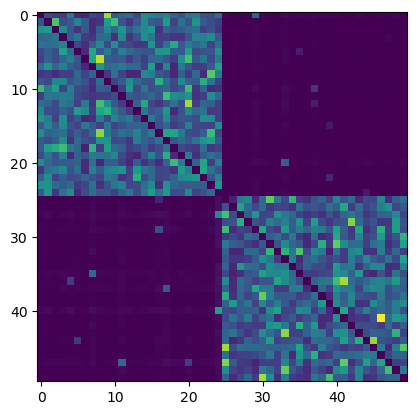

In [ ]:
plt.imshow(stepIV.data.cpu())

## Metrics

### Retraining

In [780]:
from community.funcspec.bottleneck import readout_retrain

steps = [str(community.min_t_comms - 1), "last"]

community.to(device)

retrain_outs = [
    readout_retrain(
        community,
        loaders,
        config,
        n_epochs=5,
        use_tqdm=True,
        chosen_timesteps=steps,
        n_hid=30,
        task="both",
        device=device,
    )
    for community in [networks[0]]
];

bottleneck_metrics, retrained_nets = [[b[i] for b in retrain_outs] for i in range(2)]

Bottleneck Metric Trials :   0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

In [781]:
det = lambda M: np.abs(np.linalg.det(M))
diff_metric = lambda col: (col[0] - col[1]) / col.sum()

def plot_metric(metric):

    n_steps = len(metric)
    fig, axs = plt.subplots(1, n_steps, figsize=(10, 3), constrained_layout=True)

    if n_steps == 1:
        axs = [axs]

    for s, ax in enumerate(axs):

        im = ax.imshow(metric[s])

        ax.set_ylabel("agents")
        ax.set_xlabel("Task")

        ax.set_yticks(range(len(metric[s])))
        ax.set_yticklabels([0, 1, 'Common'][:len(metric[s])])
        ax.set_xticks(range(len(metric[s][0])))

        fig.colorbar(im, ax=ax)

        ax.set_title(
            f"Det = {det(metric[s][:2]) :.3E} \n Normed Det = {det(metric[s][:2]) / metric[s][:2].sum(0).prod() :.3E}"
        )

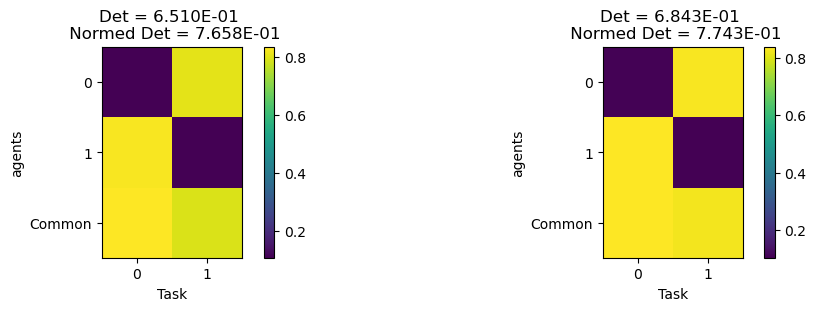

In [782]:
[plot_metric(np.stack([b["accs"][s] for s in range(len(steps))])) for b in bottleneck_metrics];

### Specialization Gradient

In [783]:
diff_metric = lambda col: (col[0] - col[1]) / col.sum()

spec_per_network = []

for n, network in enumerate(networks) : 

    diffs_ag_ts = [
        diff_metric(bottleneck_metrics[n]["accs"][ts, ag])
        for ts, ag in [[0, 0], [1, 0], [1, 2], [1, 1], [0, 1]]
    ]

    spec_per_network.append(diffs_ag_ts)

In [784]:
spec_per_network = np.array(spec_per_network)

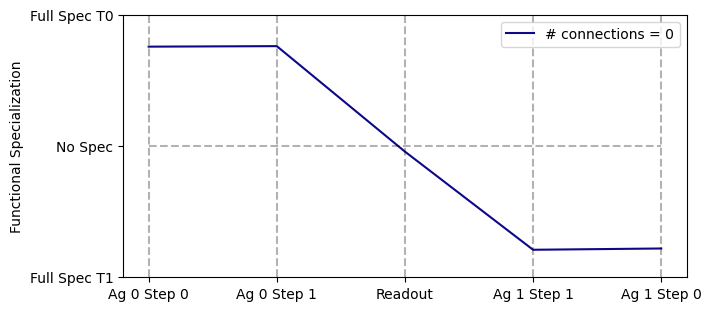

In [566]:
from matplotlib import cm

x = [-2, -1, 0, 1, 2]
x_labels = [f"Ag {ag} Step {t}" for t, ag in [[0, 0], [1, 0], [1, 1], [0, 1]]]
x_labels.insert(2, "Readout")

colors = cm.get_cmap('plasma', 3).colors

fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)
for spec, c, n in zip(spec_per_network, colors, n_conns) : 
    p = ax.plot(x, spec, c=c, label=f'# connections = {n}')

ax.set_xticks(x)
ax.set_xticklabels(labels=x_labels)
ax.set_ylim(-1, 1)
ax.set_ylabel("Functional Specialization")
ax.set_yticks([-1, 0, 1], ["Full Spec T1", "No Spec", "Full Spec T0"])
ax.hlines(0, -2, 2, linestyles="--", colors="black", alpha=0.3)
ax.vlines(x, -1, 1, linestyles="--", colors="black", alpha=0.3)
ax.legend()

#plt.colorbar(cm.get_cmap('plasma', 3))

fig.show()

In [567]:
torch.where(datasets[0].data[1][:, 1] == 5)[0]

tensor([    9,    14,    17,  ..., 59973, 59997, 59999])

In [477]:
targets = datasets[0].data[1][:, 0]

t_idxs = [torch.where(targets == t)[0] for t in range(10)] 
c_idxs = [torch.where(targets != t)[0] for t in range(10)] 

idxs = [np.concatenate((t_idx, c_idx)) for t_idx, c_idx in zip(t_idxs, c_idxs) ]

p = 0

if p != 0 : 
    ps = [np.concatenate( ( np.ones_like(t_idx) * p / len(t_idx) , (1 - p) * np.ones_like(c_idx) / len(c_idx) ) )   for t_idx, c_idx, idx in zip(t_idxs, c_idxs, idxs) ]
else : 
    ps = [np.concatenate( ( np.ones_like(t_idx)  , np.ones_like(c_idx) ) ) / len(idx) for t_idx, c_idx, idx in zip(t_idxs, c_idxs, idxs) ]

In [478]:
[p.sum() for p in ps ]

[1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004]

In [479]:
selected_idxs = [np.random.choice(idxs[t], size=len(t_idx), p=ps[t]) for t, t_idx in enumerate(t_idxs)]

In [480]:
sorted_idxs = np.argsort(targets)

In [481]:
new_targets = torch.concatenate([targets[s_idx] for s_idx in selected_idxs])

In [482]:
new_targets

tensor([9, 2, 9,  ..., 0, 6, 2])

In [483]:
(new_targets == targets[sorted_idxs]).float().mean()

tensor(0.0992)

### Correlation

In [785]:
from community.funcspec.correlation import fixed_information_data, get_correlation, v_pearsonr, randperm_no_fixed, get_pearson_metrics

In [766]:
f_data = fixed_information_data(data, target, fixed=1)

In [768]:
f_data[0].shape

torch.Size([2, 44, 1568])

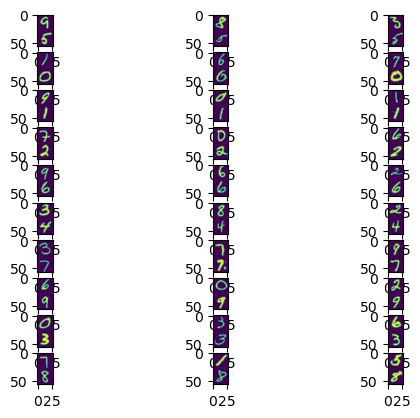

In [770]:
fig, axs = plt.subplots(len(f_data), 3)

for f_ax, f_d in zip(axs, f_data) : 
    for ax, d in zip(f_ax, f_d[0, :3, :] ) : 
        
        ax.imshow(d.reshape((2*28, 28)))


In [741]:
f_data[0].shape

torch.Size([2, 2, 44, 784])

In [734]:
torch.stack(data.split(data.shape[-1]//2, dim=-1), 1)

torch.Size([2, 2, 512, 784])

In [730]:
data.split(2, dim=-1)[0].shape

torch.Size([2, 512, 2])

In [685]:
data.shape

torch.Size([2, 512, 1568])

In [696]:
f_data[0].shape

torch.Size([2, 2, 67, 1568])

In [786]:
pearson_metrics = [get_pearson_metrics(net, loaders, config, chosen_timesteps=steps, device=device) for net in networks]

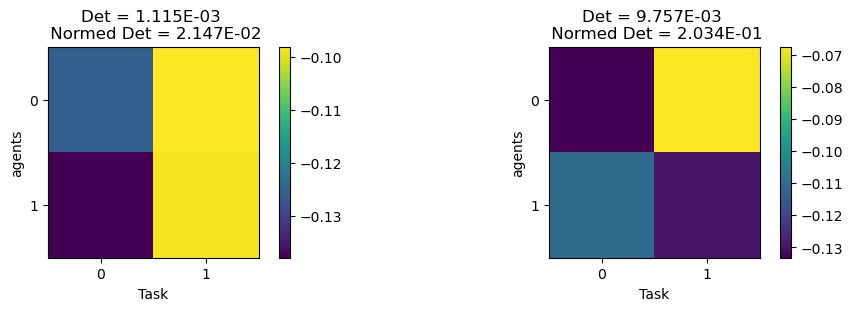

In [787]:
[plot_metric(np.stack([p["mean_corrs"][s] for s in range(len(steps))])) for p in pearson_metrics];


### Return of the masks

In [ ]:
from community.funcspec.masks import (
    train_and_get_mask_metric,
    Mask_Community,
    get_proportions,
    get_proportions_per_agent,
    GetSubnet_global,
    find_optimal_sparsity,
    train_mask,
)


In [ ]:
mask_metrics, masked_coms = train_and_get_mask_metric(
    community,
    0.1,
    loaders,
    config,
    n_epochs=10,
    lr=1e-2,
    use_optimal_sparsity=False,
    device=torch.device("cuda"),
    use_tqdm=True,
    chosen_timesteps=steps,
)

Mask Metric Trials :   0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
masked_coms[0][1].proportions.sum()

1.0

In [ ]:
mask_metrics["test_accs"]

array([0.32356771, 0.65190972])

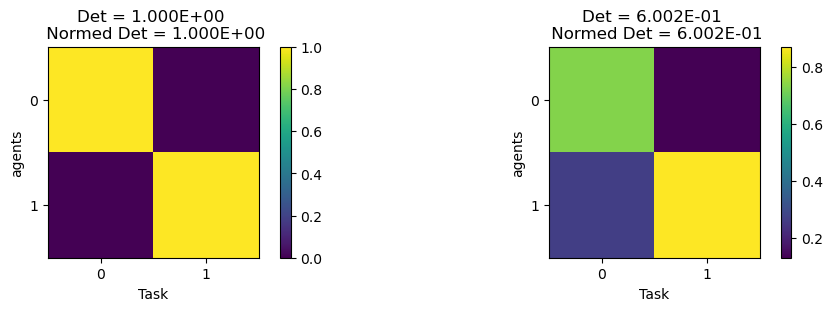

In [ ]:
plot_metric(mask_metrics["proportions"])

### Shapley Values / ablations

In [788]:
from msapy import msa, utils as ut
from community.common.decision import get_decision
from community.common.training import get_loss
from shapley import compute_shapley_values
from functools import partial


In [789]:
nodes = list(np.arange(n_agents * config["model"]["agents"]["n_hidden"]).astype(str))
nodes_int = np.arange(n_agents * config["model"]["agents"]["n_hidden"])


#### ag ablations

In [790]:
from community.common.training import test_community


In [791]:
_, retrained_nets = deepcopy([[b[i] for b in retrain_outs] for i in range(2)])
for net in retrained_nets : 
    net.readout_config['readout_from'] = None
    net.readout = net.readout[-1]

In [792]:
ablation_config = get_training_dict(deepcopy(config))
ablation_config['task'] = 'both'
ablation_config['decision'][1] = 'all'
ablation_config['decision'][0] = 'last'


In [793]:
ablated_accs  = [[test_community(net, device, loaders[1], ablation_config, ag_masks=[torch.ones(n_hidden) * (ag != i)  for i in range(2)] )[2]  for ag in range(2)]  for net in retrained_nets]
ablated_accs

[[array([0.7582237, 0.0962171], dtype=float32),
  array([0.10207648, 0.8290502 ], dtype=float32)]]

In [794]:
community(data, state_masks = [torch.zeros(n_hidden)  for i in range(2)])[1]['ag_outputs']

[[tensor([[[ 0.3404, -1.8563, -0.8633,  ..., -0.3418,  0.1571,  0.5258],
           [ 0.3404, -1.8563, -0.8633,  ..., -0.3418,  0.1571,  0.5258],
           [ 0.3404, -1.8563, -0.8633,  ..., -0.3418,  0.1571,  0.5258],
           ...,
           [ 0.3404, -1.8563, -0.8633,  ..., -0.3418,  0.1571,  0.5258],
           [ 0.3404, -1.8563, -0.8633,  ..., -0.3418,  0.1571,  0.5258],
           [ 0.3404, -1.8563, -0.8633,  ..., -0.3418,  0.1571,  0.5258]],
  
          [[ 0.3082,  0.3546,  0.2366,  ..., -0.5494, -0.9775, -0.9301],
           [ 0.3082,  0.3546,  0.2366,  ..., -0.5494, -0.9775, -0.9301],
           [ 0.3082,  0.3546,  0.2366,  ..., -0.5494, -0.9775, -0.9301],
           ...,
           [ 0.3082,  0.3546,  0.2366,  ..., -0.5494, -0.9775, -0.9301],
           [ 0.3082,  0.3546,  0.2366,  ..., -0.5494, -0.9775, -0.9301],
           [ 0.3082,  0.3546,  0.2366,  ..., -0.5494, -0.9775, -0.9301]]],
         grad_fn=<SqueezeBackward0>),
  tensor([[[ 0.3404, -1.8563, -0.8633,  ..., -0.

In [795]:
ablated_accs_ratio = [a /bottleneck_metrics[0]['accs'][1][-1]  for a in ablated_accs]

In [796]:
ablated_accs = np.array(ablated_accs)
ablated_accs_ratio =  1 - np.array(ablated_accs_ratio)

ablated_accs_ratio

array([[[ 0.09385747,  0.88349515],
        [ 0.87800986, -0.00385869]]], dtype=float32)

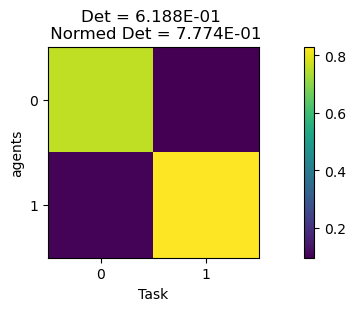

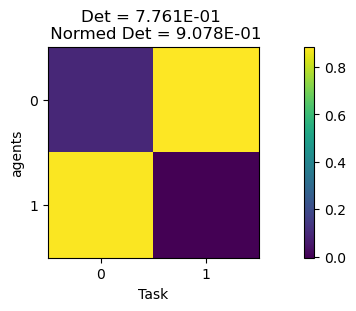

In [797]:
[plot_metric(a) for a in [ablated_accs, ablated_accs_ratio]];

In [675]:
np.geomspace(10, 100, 5, dtype=int).round(2)

array([ 10,  17,  31,  56, 100])

#### shap

In [155]:
parallel = False

n_permutations = 20


shapley_outs = [compute_shapley_values(
    net, nodes, n_permutations, loaders, config, parallel
) for net in retrained_nets]


'''
 (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        )
'''

Task 0 : Performance without ablations : 0.82373046875


100%|██████████| 361/361 [00:06<00:00, 59.10it/s]


Task 1 : Performance without ablations : 0.7958984375


100%|██████████| 361/361 [00:06<00:00, 59.23it/s]


'\n (\n            shapley_tables,\n            shapley_tables_avg,\n            all_accs,\n            contributions,\n            lesion_effects,\n        )\n'

In [156]:
import pandas as pd

In [157]:
avg_shap_pds = [pd.DataFrame.from_dict(
    {
        "node": nodes_int,
        "task_0": shap_out[1][0],
        "task_1": shap_out[1][1],
    }
)
    for shap_out in shapley_outs]

In [161]:
len(shapley_outs)

1

[<AxesSubplot: xlabel='node'>]

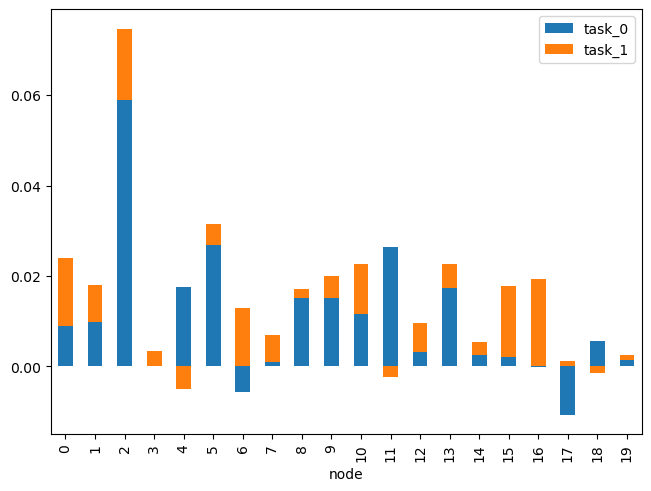

In [162]:
fig, axs = plt.subplots(len(avg_shap_pds), constrained_layout=True)
try : 
    axs[0]
except TypeError : 
    axs = [axs]
[shap_pd.plot(x="node", kind="bar", stacked=True, ax=ax) for shap_pd, ax in zip(avg_shap_pds, axs)]


In [163]:
shapley_metrics = [np.array(
    [
        [
            avg_shap_pd[
                (i * n_hidden <= avg_shap_pd["node"])
                * (avg_shap_pd["node"] < (i + 1) * n_hidden)
            ][f"task_{t}"].mean()
            for t in range(2)
        ]
        for i in range(n_agents)
    ]
) for avg_shap_pd in avg_shap_pds]


[None]

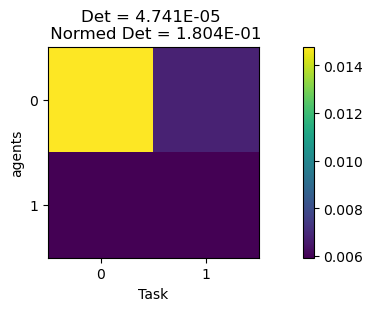

In [164]:
[plot_metric([shapley_metric]) for shapley_metric in shapley_metrics]


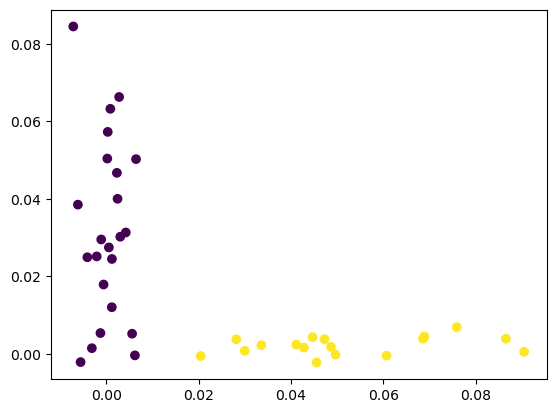

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(2)
all_shapley = pd.concat(shapley_tables_avg, axis=1)
km.fit(all_shapley)
kmeans_labels = km.labels_

plt.scatter(shapley_tables_avg[0], shapley_tables_avg[1], c=kmeans_labels)

In [ ]:
shapley_table, contributions, lesion_effects = msa.interface(
    multiprocessing_method="joblib",
    elements=nodes,
    n_permutations=10,
    objective_function=masked_inference,
    n_parallel_games=24,
)

# Stability

In [ ]:
for ag in community.agents:
    eigens = torch.linalg.eigvals(ag.w_rec).cpu().data
    plt.figure()
    plt.scatter(eigens.real, eigens.imag)


In [ ]:
for state in states.transpose(0, 1).cpu():
    plt.figure()
    for s in state.transpose(0, -1):
        plt.plot(range(6), s.mean(0).cpu().data)


# New Data Gen

In [ ]:
labels, centers = datasets[0].data[1:]
centers = centers.transpose(0, 1)
symbols = datasets[0].symbols
symbol_size = datasets[0].symbol_size
centers.shape


In [ ]:
data_size = 10000
input_size = 60
n_steps = centers.shape[0]
n_symbols = centers.shape[-2]
symbol_assignments = [datasets[0].get_random_symbol_assignement(l) for l in labels]


In [ ]:
def fill_grid(idxs):
    # grids = np.zeros((n_steps, data_size, input_size, input_size))
    time_step, data_idx, symbol = idxs
    center_pos = centers[time_step, data_idx, symbol]
    label = symbol_assignments[data_idx][symbol]
    grids[
        time_step,
        data_idx,
        center_pos[0] : center_pos[0] + symbol_size,
        center_pos[1] : center_pos[1] + symbol_size,
    ] += symbols[label]
    # return grids


@ray.remote
def fill_grid_data(time_step):

    grids = np.zeros((data_size, input_size, input_size))
    for data_idx in range(data_size):
        for symbol in range(n_symbols):
            center_pos = centers[time_step, data_idx, symbol]
            label = symbol_assignments[data_idx][symbol]
            grids[
                data_idx,
                center_pos[0] : center_pos[0] + symbol_size,
                center_pos[1] : center_pos[1] + symbol_size,
            ] += symbols[label]

    return grids


def old_method():
    grids = []

    def assign_square(grid, center_pos, l, d):
        grid[
            d,
            center_pos[0] : center_pos[0] + symbol_size,
            center_pos[1] : center_pos[1] + symbol_size,
        ] += symbols[l]

    for center in centers:
        grid = np.zeros((data_size, input_size, input_size))
        for d in range(data_size):
            for i, c in enumerate(center[d]):
                # l = int(i < labels[d])
                assign_square(grid, (c[0], c[1]), symbol_assignments[d][i], d)

        grids.append(grid)

    grids = np.stack(grids)

    return grids


time_data_and_sym = [
    [t, d, i]
    for t in range(n_steps)
    for d in range(data_size)
    for i in range(n_symbols)
]


In [ ]:
import ray

num_cpus = 24

grids = np.zeros((n_steps, data_size, input_size, input_size))

grids_id = ray.put(grids)


prof = profile.Profile()
prof.enable()

grids = np.stack(ray.get([fill_grid_data.remote(idx) for idx in range(n_steps)]))
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))
vect_fill = np.vectorize(fill_grid, signature="(N)->()")

prof = profile.Profile()
prof.enable()

grids = vect_fill(time_data_and_sym)
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))

prof = profile.Profile()
prof.enable()

grids = [fill_grid(idx) for idx in time_data_and_sym]

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
prof = profile.Profile()
prof.enable()

grids_old = old_method()
print(grids_old.shape)
prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
from joblib import delayed, Parallel


In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack([fill_grid_data(d) for d in trange(n_steps)])
grids.shape

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack(
    Parallel(24, max_nbytes=1e12, backend="multiprocessing")(
        delayed(fill_grid_data)(idx) for idx in trange(n_steps)
    )
)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows
